## Метрика линеаризованных лайков
Считаем общий CTR в контрольной группе  𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙=𝑠𝑢𝑚(𝑙𝑖𝑘𝑒𝑠)/𝑠𝑢𝑚(𝑣𝑖𝑒𝑤𝑠) 
Посчитаем в обеих группах поюзерную метрику  𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠=𝑙𝑖𝑘𝑒𝑠−𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙∗𝑣𝑖𝑒𝑤𝑠 
После чего сравним  t-тестом отличия в группах по метрике 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠  
Метод простой, гарантируется, что при приличном размере выборки (как у нас — подойдет) можно бесплатно увеличить чувствительность вашей метрики (или, по крайней мере, не сделать хуже).

Задача

1. Проанализируйте тест между группами 0 и 3 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше?
2. Проанализируйте тест между группами 1 и 2 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше?

In [5]:
# Импортируем необходимые библиотеки

import pandas as pd
import pandahouse as ph
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline

In [6]:
# Подключаемся к БД

connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20230720',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

## Сравним группы 0 и 3

In [7]:
# Делаем запрос необходимых данных 
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-06-30' and '2023-07-06'
    and exp_group in (0,3)
GROUP BY exp_group, user_id
"""

df = ph.read_clickhouse(q, connection=connection)

In [8]:
# Проверим количество пользователей в каждой группе
df.groupby('exp_group').user_id.count()

exp_group
0     9920
3    10002
Name: user_id, dtype: int64

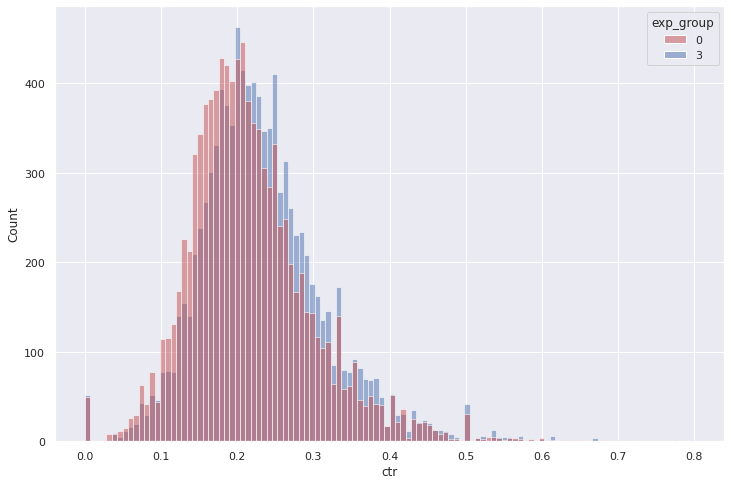

In [9]:
# Построим график, чтобы посмотреть на наши данные
sns.set(rc={'figure.figsize':(12, 8)})
groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

На графике видим, что данные распределены равномерно и примерно одинаково.

In [10]:
# Проведем t-тест
stats.ttest_ind(df[df.exp_group == 0].ctr,
                df[df.exp_group == 3].ctr,
                equal_var=False)

Ttest_indResult(statistic=-13.935320516755773, pvalue=6.216047483062228e-44)

t-тест показал, что существенных различий нет

Проведем t-тест в группах по метрике linearized_likes:

In [11]:
# Считаем общий CTR для контрольной группы
ctr_control = df[df.exp_group == 0].likes.sum()/df[df.exp_group == 0].views.sum()
ctr_control

0.20983799195924746

In [12]:
df['linearized_likes'] = df.likes - ctr_control * df.views

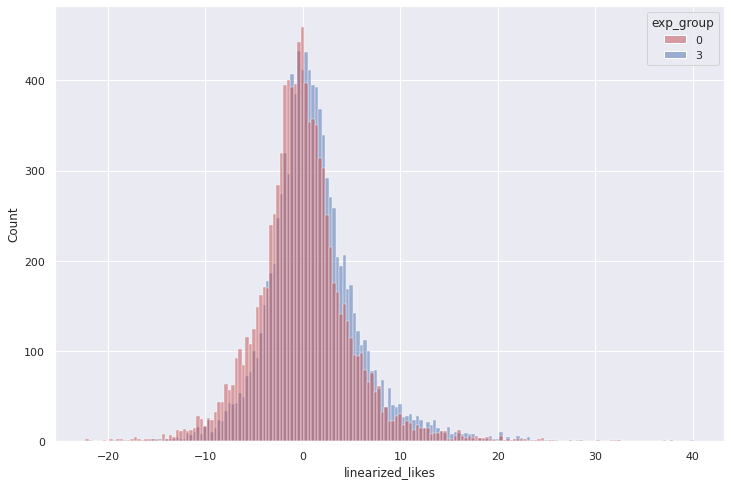

In [13]:
# Построим график, чтобы посмотреть на наши данные
sns.set(rc={'figure.figsize':(12, 8)})
groups = sns.histplot(data = df, 
              x='linearized_likes', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

In [14]:
stats.ttest_ind(df[df.exp_group == 0].linearized_likes,
                df[df.exp_group == 3].linearized_likes,
                equal_var=False)

Ttest_indResult(statistic=-16.186230032932844, pvalue=1.4918137745326139e-58)

Отличия видны: p-value стало значительно меньше, а также распределение в группах стало "более" нормальным

## Сравним группы 1 и 2

In [15]:
# Делаем запрос необходимых данных 
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-06-30' and '2023-07-06'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""

df_2 = ph.read_clickhouse(q, connection=connection)

In [16]:
# Проверим количество пользователей в каждой группе
df_2.groupby('exp_group').user_id.count()

exp_group
1    10020
2     9877
Name: user_id, dtype: int64

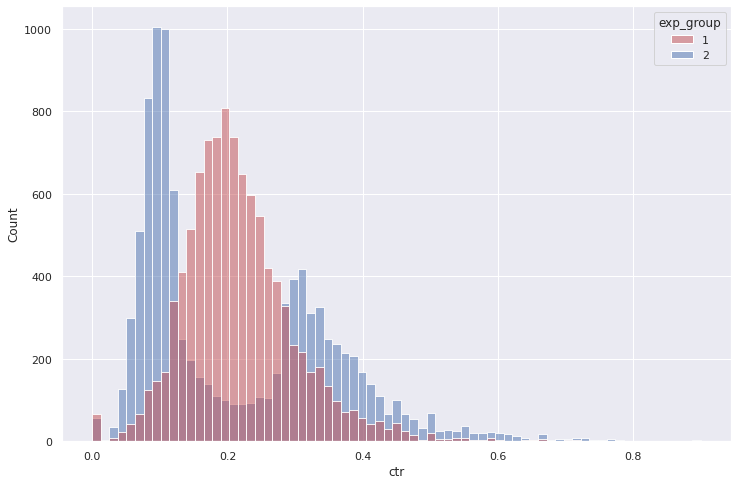

In [17]:
# Построим график, чтобы посмотреть на наши данные
sns.set(rc={'figure.figsize':(12, 8)})
groups = sns.histplot(data = df_2, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

Видим,что в первой контрольной группе распределение похоже на нормальное, а во второй нет. Видно, что распределения сильно отличаются

In [18]:
# Проведем t-тест
stats.ttest_ind(df_2[df_2.exp_group == 1].ctr,
                df_2[df_2.exp_group == 2].ctr,
                equal_var=False)

Ttest_indResult(statistic=0.4051491913112757, pvalue=0.685373331140751)

Тест показывает, что статистически важных различий нет, скорее всего это из-за того, что во второй группе распределение далеко от нормального

Проведем t-тест в группах по метрике linearized_likes:

In [19]:
# Считаем общий CTR для контрольной группы
ctr_control = df_2[df_2.exp_group == 1].likes.sum()/df_2[df_2.exp_group == 1].views.sum()
ctr_control

0.2096041628394293

In [20]:
df_2['linearized_likes'] = df_2.likes - ctr_control * df_2.views

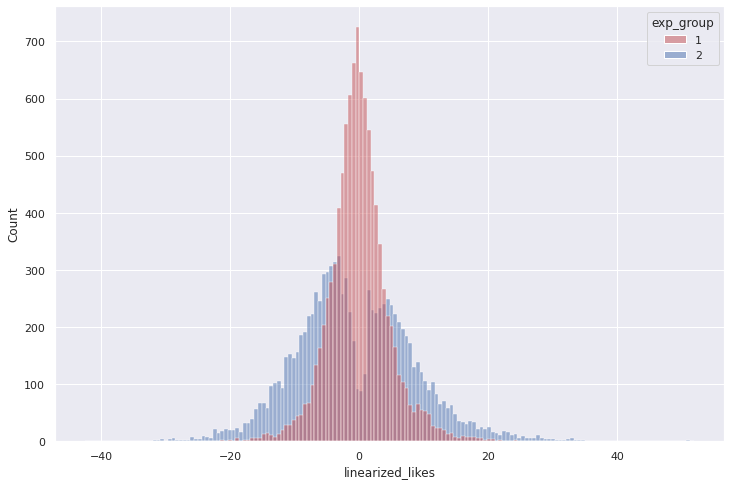

In [22]:
# Построим график, чтобы посмотреть на наши данные
sns.set(rc={'figure.figsize':(12, 8)})
groups = sns.histplot(data = df_2, 
              x='linearized_likes', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

In [23]:
stats.ttest_ind(df_2[df_2.exp_group == 1].linearized_likes,
                df_2[df_2.exp_group == 2].linearized_likes,
                equal_var=False)

Ttest_indResult(statistic=5.936377101934481, pvalue=2.9805064038667945e-09)

Отличия видны: p-value стало значительно меньше и показывает, что есть статистически значимые различия.  

## Вывод:
1. Для групп 0 и 3 t-тест показал статистически значимые различия с маленькими p-value в обоих случаях. Но после t-теста на линеаризованных лайках значение p-value стало намного меньше, чем при тесте на CTR. Это свидетельствует о большей чувствительности метрики линеаризованных лайков.
2. Для групп 1 и 2 t-тест на CTR не показал статистически значимых различий. Но после t-теста на линеаризованных лайках значение p-value оказалось намного меньше 0.05, что свидетельствует о том, что статистически важные различая между группами все-таки есть. Это еще раз подтверждает, что метрики линеаризованных лайков обладает большей чуствительностью, чем t-тест на обычном CTR.